# What's New in OpenPNM V3


```{post} 2022-10-10
:tags: openpnm
:redirect: openpnm-v3-overview
```

It's been a long process, much longer than we would've liked, but OpenPNM Version 3.0 is finally here. Version 2.0 was released in August 2018, and version 2.8.2, the last of the V2 series, was released in September 2021. This 3 year stretch saw a lot growth in the OpenPNM userbase, which if we use the Github star count as a proxy, showed a 300% increase over the period!

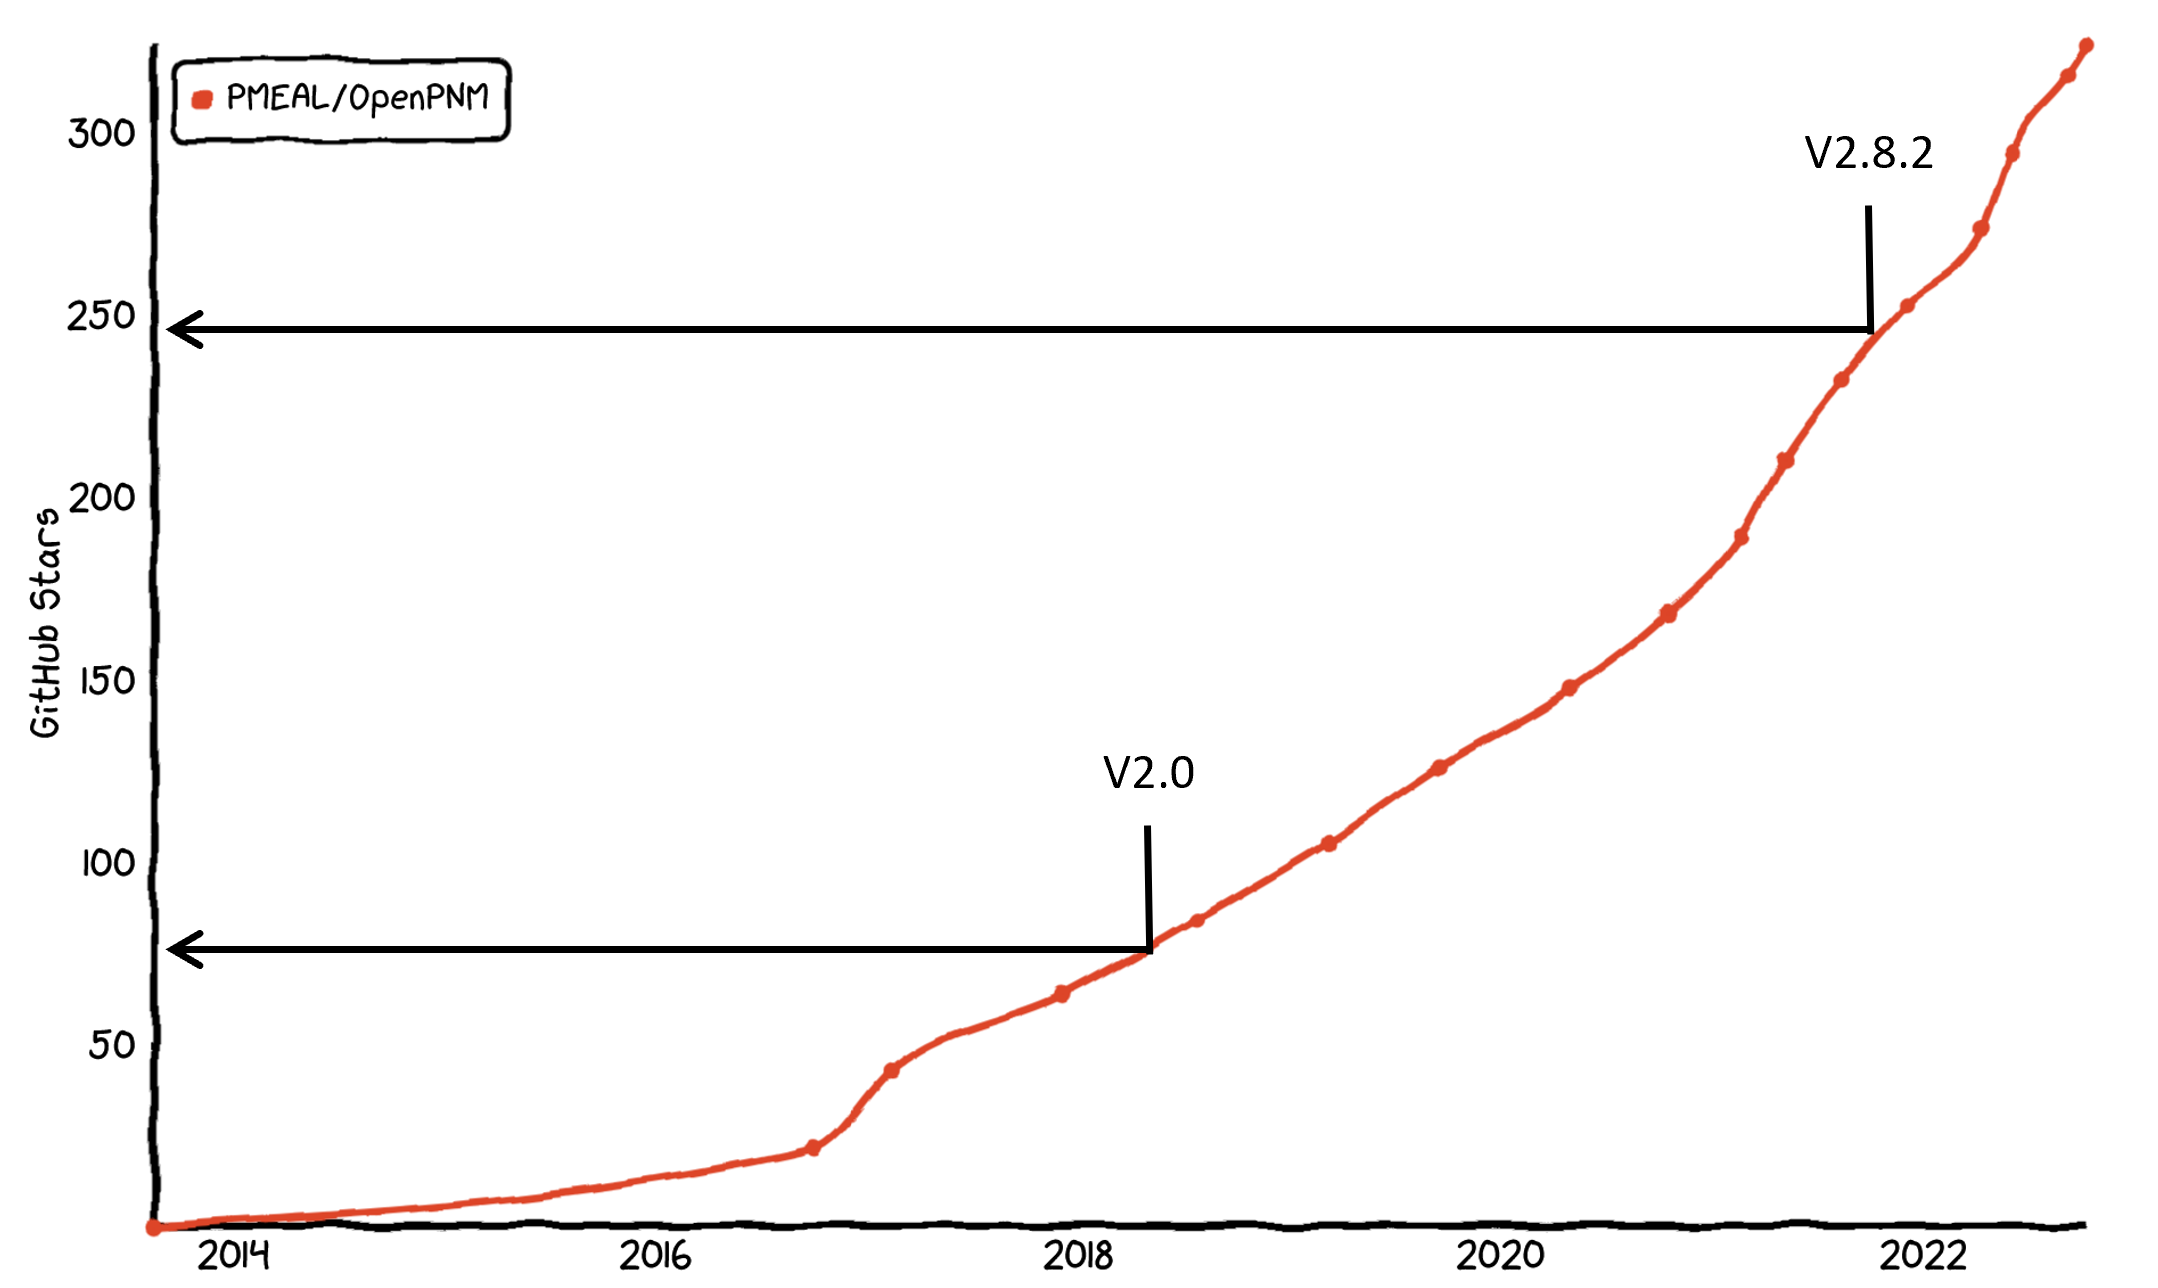

A lot has happened over these three years, and it's been quite a blur so it's hard to remember which milestones to highlight. One major event was the PMEAL group receiving funding from CANARIE to support the growth of OpenPNM (and PoreSpy). This funding allowed for the hiring of many highly talented students who really took OpenPNM to the next level. 

## Overview of the Biggest Change

There have been a LOT of useful and powerful additions to V3, but perhaps the biggest change is what's missing:

> V3 has removed the concept of `Geometry` and `Physics` objects. This "workflow" was invented on the whiteboard during our initial planning sessions for V1 in 2011, and looked sensible at the time, but over the past 10+ years it became clear that this created a lot of confusion for users and a friction for the developers. 

For comparison let's look at how this changes the scripts. In version 2 you'd initialize 4 objects:

``` python
import openpnm as op

pn = op.network.Cubic(shape=[5, 5, 5], spacing=1e-5)
geo = op.network.SphersAndCylinders(network=pn, pores=pn.Ps, throats=pn.Ts)
air = op.phases.Air(network=pn)
phys = op.physics.Standard(network=pn, geometry=geo, phase=air)

```

While in version 3 the same result is obtained as follows:

``` python
import openpnm as op

pn = op.network.Cubic(shape=[5, 5, 5], spacing=1e-5)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
air = op.phase.Air(network=pn)
air.add_model_collection(op.models.collections.physics.standard)

```

This difference results in several important changes:

---
**Back End Simplicity:** 
The 'back-end' code complexity was *massively* reduced, which will make it far easier to maintain OpenPNM moving forward. There was quite a lot of *machinery* dedicated to tracking which pores and throats were assigned to `geo`, and that `phys` was associated with `geo`. For instance, in cases where multiple domains were used, such as `geo1` and `geo2` a lot of checks were done behind the scenes to ensure they did not conflict with each other and that all pores and throats were accounted for. There was also functionality required for 'redefining' which pores and throats they were applied to, and so on. Easily thousands of lines of code were deleted by this change.

---
**Fewer Objects to Think About:** 
Speaking of multiple domains, most users probably did not use this capability, but for those who did (like PMEAL group members!) this change will result in a much simpler experience. In most cases the effects of multiple domains was only relevant to geometries, so one might specify `geo1` and `geo2` each with different pore size distributions, but probably the same physics applied to each domain. In the old approach, you had to create a unique physics associated with each subdomain, but now you can just add a single set of physics models to a phase and they can apply everywhere.

---
**Emphasizes Pore-Scale Models:**
Although we've attempted to make this as smooth as possible, there is no such thing as a free lunch, and the user must still invest some effort in defining which models to assign (and where). We have created *collections* to facilitate this process, which are demonstrated above. A positive take of this new approach is that users are now forced interact with pore-scale models, which are the foundation of OpenPNM's calculations, so hopefully this encourage them to write and use their own models.

---
**Easy Multidomain Control:**
We have created a new way defining multiple domains, or more to the point, we created a way to assign different pore-scale models to specific pores. In the `pn.models` dictionary you will find all the models defined on the network, but now each model name also includes the domain where it applies, so instead of `'pore.diameter'`, it's `'pore.diameter@<xyz>'`, where `@` is a delimiter and `<xyz>` is the name of a label on the network. The default is `'@all'`, meaning the model applies everywhere. To create two domains with different pore sizes you now define different models such as `pn.models['pore.diameter@domain1']` and `pn.models['pore.diameter@domain2']`. Conveniently, you don't need to specify different models for *other* properties like `'pore.volume'` (unless you want to).

The best way to illustrate this change is by example. The code snippets below will create a multiphase domain with 2 different pore sizes, but all other models the same. It will then *change* the domains so that different pores are assigned to each domain.

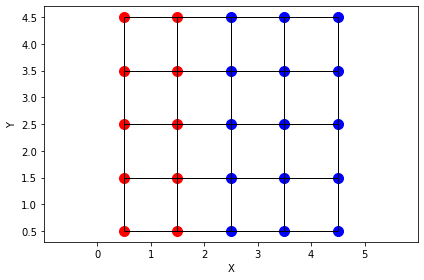

In [56]:
import openpnm as op
pn = op.network.Cubic(shape=[5, 5, 1], spacing=1.0)
Ps1 = pn.coords[:, 0] < 2
pn.set_label(label='domain1', pores=Ps1)
pn.set_label(label='domain2', pores=~Ps1)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('domain1'), c='r', s=100)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('domain2'), c='b', s=100, ax=ax)
op.visualization.plot_connections(pn, c='k', ax=ax);

Now let's retrieve the `stick_and_ball` geometry model collection, create a copy, alter the pore sizes on one of them, then assign each to different pores:

In [57]:
mods1 = op.models.collections.geometry.spheres_and_cylinders
mods2 = mods1.copy()

In [58]:
pn.add_model_collection(mods1, domain='domain1')
pn.add_model_collection(mods2, domain='domain2')

Let's replace the model used for computing the pore diameter with a random number between some limits

In [59]:
pn.add_model(propname='pore.diameter', 
             model=op.models.geometry.pore_size.random,
             num_range=[0.01, 0.2],
             domain='domain1')
pn.add_model(propname='pore.diameter', 
             model=op.models.geometry.pore_size.random,
             num_range=[0.8, 0.99],
             domain='domain2')

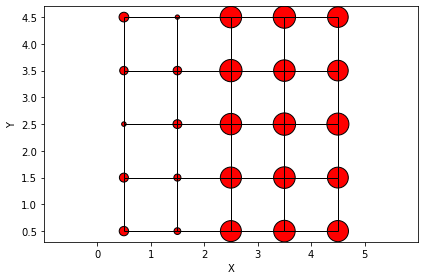

In [60]:
ax = op.visualization.plot_coordinates(network=pn, s=500, size_by=pn['pore.diameter'], edgecolor='k')
op.visualization.plot_connections(pn, c='k', ax=ax);

This new approach may take some getting used to, but hopefully it has enough upsides to make it worth the it.  We don't dive into all of these here, but let's just look at one feature which will hopefully make it clear why this new approach simplifies the back-end.  Lets change which pores belong to `domain1` and `domain2`.  In the previous version this required calls to the `set_locations` methods of all the geometry objects. In V3 we just need to change some pore labels and regenerate the models:

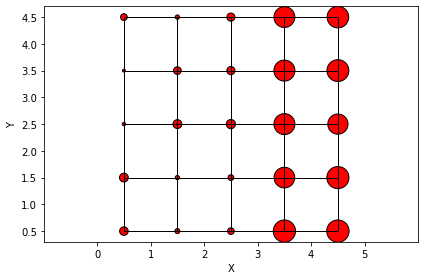

In [61]:
pn.set_label(label='domain1', pores=pn.coords[:, 0] < 3, mode='overwrite')
pn.set_label(label='domain2', pores=pn.coords[:, 0] > 3, mode='overwrite')
pn.regenerate_models()
ax = op.visualization.plot_coordinates(network=pn, s=500, size_by=pn['pore.diameter'], edgecolor='k')
op.visualization.plot_connections(pn, c='k', ax=ax);

## Other Important Changes

There have been a handful of other *breaking* changes including:

- Renaming of the `phases` module to `phase`. This was purely cosmetic so that all modules have consistant pluralization.
- Removed the term "Generic" from the numerous class names to avoid overly complicating things. Instead of instantiating a `GenericPhase` it is now just `Phase`.
- Moving of the plotting tools to a new `visualization` module. Previously they were in `topotools` which was no really obvious.
- Overhaul of the `io` module to be a collection of clearly named functions like `network_from_statoil` rather than categorized functions like `statoil.load`. This is more consistant with other packages like `pandas` which offer functions like `from_csv`.
- The Bravais network generator has been removed in favor of specificly named classes like `FaceCenteredCubic` and `BodyCenteredCubic`.
- A lot of minor functions and features were removed. This was done in the spirit of keeping the code base small and manageble, which we'd grown to realize was a very important design consideration. 
- Subdictionaries now work as expected, so that `pn['pore.conduit_length']['pore1']` works the same as `pn['pore.conduit_length.pore1']`. We also updated many of the models to return Nt-by-3 arrays of conduit properties rather than a dictionary. 
- Migrated to a new documentation engine and website generator, which creates very beautiful example pages from jupyter notebooks, making it super easy to write a high quality and detailed tutorial for the website. This paved the way for the next few items...
- Removal of the `metrics` module, in favor of creating detailed examples on the website. We created these metrics as a way to make OpenPNM *even easier* to use, but they only obscurred from the user what were relatively simple calculations. 
- Removal of the `materials` module, which will also be replaced by detailed examples on the website.

## Exciting Additions

- Transient solvers have been extended substantially. In V2 we'd implemented the basic Implicit and Crank-Nicolson methods, while in V3 we leverage the `scipy.integrate.ivp_solve` library to access their high-order explicit solvers. In V3.0 we have created wrappers for RK45, but more are planned.  These wrappers are in the new `integrators` module.
- Redesigned the numerical solver framework. We added a new module called `solvers` containing classes which define how to wrap any arbitrary numerical solver library. At present we have wrappers for `pypardiso` and `scipy.linalg.spsolve`, but more are planned.
- A framework for estimating physical properties of mixtures. This is based on the `chemicals` package and provides a first approximation for computing properties that are functions on composition which may change during a simulation.
- Complete rewrite of the ordinary percolation algorithm, now called `Drainge`. 
- Definition of *pore size factors* which contain all the information about the shape of pores and throats. This means that computing of diffusive flow through an element is done as $N_A = D_{AB} \cdot f_{size} \Delta C_A$ where the length and area of the element are embedded in $f_{size}$ which includes a rigorous analyztical description of the changing cross-sectional shape.

## Full Changelog on Github
During this past 3 years we've also migrated all of our continuous integration testing and release process to Github Actions. One of the great side effects of this that we can now generate very detailed changelogs from the commit messages for each merge onto the `dev` branch. The full change can be [viewed here](https://github.com/PMEAL/OpenPNM/releases).